1. ****학습에 필요한  module을 불러와준다****

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
import random
import os,shutil
from sklearn.model_selection import train_test_split
from keras import applications
from keras import layers
from keras import models
from keras import backend as K
K.set_image_dim_ordering('th')
K.set_image_data_format('channels_last')
from keras import layers
from keras import models
from keras import optimizers
from keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt
%matplotlib inline
from keras import Sequential
from keras.layers import *
import keras.optimizers as optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import *
import keras.backend as K
from tensorflow.python.keras.models import Sequential
from keras.models import load_model
from mlxtend.plotting import plot_confusion_matrix

src_path="../input"

print(os.listdir(src_path))

#constant value
VALID_SPIT=0.2
IMAGE_SIZE=80
BATCH_SIZE=20

Using TensorFlow backend.


['test', 'sample_submission.csv', 'train']


2. train폴던안에는 개고양이가 랜덤으로 들어가있는 25000개의 이미지가 들어있는데, 이미지 앞글자가 cat인경우는 0 dog일경우는 1로 설정하여 
정답레이블을 만들어주고 ,그에맞는 이미지를 나누어준다

In [2]:
label=[]
data=[]
counter=0
path="../input/train/train"
for file in os.listdir(path):
    image_data=cv2.imread(os.path.join(path,file), cv2.IMREAD_COLOR)
    image_data=cv2.resize(image_data,(IMAGE_SIZE,IMAGE_SIZE))
    if file.startswith("cat"):
        label.append(0)
    elif file.startswith("dog"):
        label.append(1)
    try:
        data.append(image_data/255)
    except:
        label=label[:len(label)-1]
    counter+=1
    if counter%1000==0:
        print (counter," image data retreived")

data=np.array(data)
data=data.reshape((data.shape)[0],(data.shape)[1],(data.shape)[2],3)
label=np.array(label)
print (data.shape)
print (label.shape)

1000  image data retreived
2000  image data retreived
3000  image data retreived
4000  image data retreived
5000  image data retreived
6000  image data retreived
7000  image data retreived
8000  image data retreived
9000  image data retreived
10000  image data retreived
11000  image data retreived
12000  image data retreived
13000  image data retreived
14000  image data retreived
15000  image data retreived
16000  image data retreived
17000  image data retreived
18000  image data retreived
19000  image data retreived
20000  image data retreived
21000  image data retreived
22000  image data retreived
23000  image data retreived
24000  image data retreived
25000  image data retreived
(25000, 80, 80, 3)
(25000,)


train data 20%를 validation 데이터로 쓴다

In [3]:
train_data, valid_data, train_label, valid_label = train_test_split(
    data, label, test_size=0.2, random_state=42)
print(train_data.shape)
print(train_label.shape)
print(valid_data.shape)
print(valid_label.shape)

(20000, 80, 80, 3)
(20000,)
(5000, 80, 80, 3)
(5000,)


1. weoimagenet으로 pretrain된 VGG 모델을 불러와준다
    설정:include_top:False
        input_shape=80x80x3(이미지)

In [4]:
vgg_model = applications.VGG19(weights='imagenet',
                               include_top=False,
                               input_shape=(80, 80, 3))

vgg_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 80, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 40, 128)       147584    
_____

In [5]:
model = models.Sequential()
model.add(vgg_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation  = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 20,549,185
Trainable params: 20,549,185
Non-trainable params: 0
_________________________________________________________________


고양이 0 , 개가 1인 이진분류이기 때문에 loss는 binary_crossentropy를 사용해줍니다.

In [7]:
model.compile(loss='binary_crossentropy',optimizer=optimizers.adam(lr=1e-4),metrics=['acc'])

학습을 시켜줍니다

In [8]:
train_history=model.fit(train_data,train_label,validation_data=(valid_data,valid_label),epochs=20,batch_size=BATCH_SIZE)

Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 59s 3ms/step - loss: 0.3780 - acc: 0.8128 - val_loss: 0.2845 - val_acc: 0.8882
Epoch 2/20
20000/20000 [==============================] - 55s 3ms/step - loss: 0.1910 - acc: 0.9232 - val_loss: 0.1787 - val_acc: 0.9268
Epoch 3/20
20000/20000 [==============================] - 55s 3ms/step - loss: 0.1331 - acc: 0.9480 - val_loss: 0.1361 - val_acc: 0.9416
Epoch 4/20
20000/20000 [==============================] - 55s 3ms/step - loss: 0.0964 - acc: 0.9627 - val_loss: 0.1425 - val_acc: 0.9440
Epoch 5/20
20000/20000 [==============================] - 54s 3ms/step - loss: 0.0777 - acc: 0.9701 - val_loss: 0.1569 - val_acc: 0.9404
Epoch 6/20
20000/20000 [==============================] - 55s 3ms/step - loss: 0.0636 - acc: 0.9772 - val_loss: 0.1700 - val_acc: 0.9430
Epoch 7/20
18280/20000 [==========================>...] - ETA: 4s - loss: 0.0419 

학습한 결과입니다

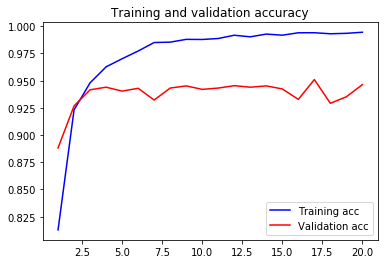

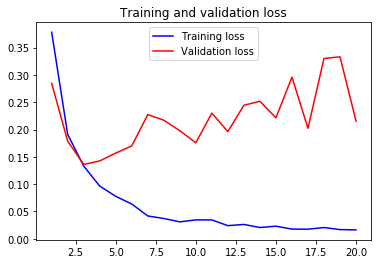

In [9]:
acc = train_history.history['acc']
val_acc = train_history.history['val_acc']
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'blue', label='Training acc')
plt.plot(epochs, val_acc, 'red', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

학습이 잘됐나 안됐나 확인을하기위해 model_predict를 해줍니다.

In [10]:
Y_pred = model.predict(valid_data)
predicted_label=np.round(Y_pred,decimals=2)

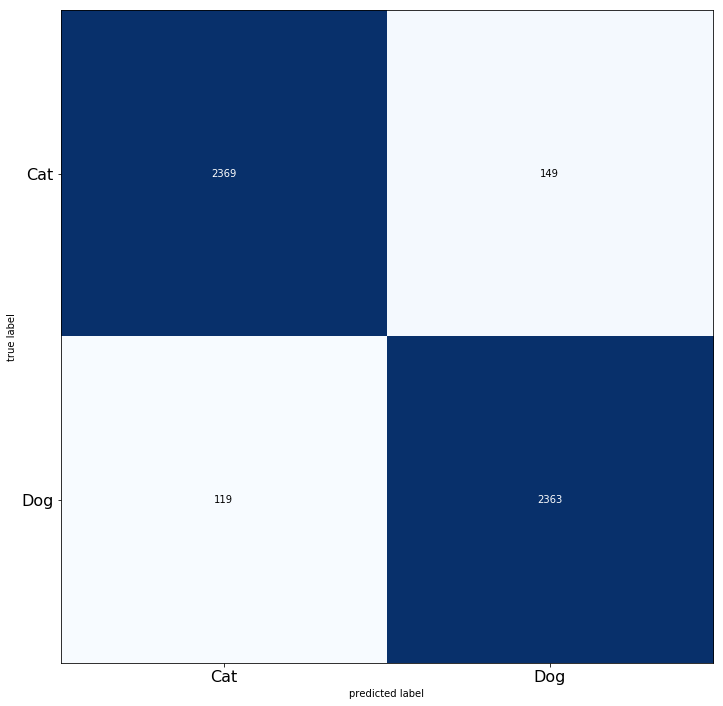

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
from mlxtend.plotting import plot_confusion_matrix

# Get the confusion matrix

CM = confusion_matrix(valid_label, Y_pred.round())
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(12, 12))
plt.xticks(range(2), ['Cat', 'Dog'], fontsize=16)
plt.yticks(range(2), ['Cat', 'Dog'], fontsize=16)
plt.show()